In [1]:
%pylab inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar
from scipy import math
import random

Populating the interactive namespace from numpy and matplotlib


# Importo il dataset

In [2]:
file = pd.read_csv(r'/home/gdeandrea/Scrivania/UNI/Econofisica/MyModels/Epstein/PRESE DATI/A-Valore Soglia/dati_rivolte')
file.head()

,x,y,color,pen down?,x.1,y.1,color.1,pen down?.1,x.2,y.2,color.2,pen down?.2
0,0,1120,55,True,0,0,0,True,0,0,15,True
1,1,1076,55,True,1,7,0,True,1,37,15,True
2,2,868,55,True,2,53,0,True,2,199,15,True
3,3,626,55,True,3,111,0,True,3,383,15,True
4,4,611,55,True,4,167,0,True,4,342,15,True


In [3]:
df = file['y.2']
y = df.to_numpy()
x = ar(range(len(y)))

# Definizioni Utili

## Fit Utils

In [4]:
def chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit[i])
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma*sigma))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)
    

def gauss(x,a,x0,sigma):
    'Ritorna array gaussiano a partire da lista x secondo i parametri a,x0,sigma'
    return a*exp(-(x-x0)**2/(sigma*sigma))


def lore(x, a, x0, y0):
    'Ritorna array lorentziano a partire da lista x secondo i parametri a,x0,yo'
    return a*(y0/(((x - x0)**2) + (y0**2)))

def fattoriale(x):
    temp_list = []

    for ics in x:
        f=1
        for i in range(1,ics+1):
            f*=i
        temp_list.append(f)
    return(temp_list)

def poisson(x, a, media):
    result = a*(media**x)*np.exp(-media)/fattoriale(x)
    return(result)

## Selecting Spikes

In [5]:
def isola_spikes (y):
    
    rivolte_diz = {}
    temp_rivolta_list = []
    rivolte_counter = 0
    cerarivolta = False
    
    for i in range(len(y)):
        
        ##aggiustato a 12 per non avere rivoltini
        if y[i] > 12:
            temp_rivolta_list.append(y[i])
            if cerarivolta == False:
                rivolte_counter += 1
                cerarivolta = True
        else:
            if cerarivolta == True:
                lunghezza=len(temp_rivolta_list)
                if rivolte_counter > 1:
                    temp_rivolta_list.insert(0, y[i-lunghezza-1])
                    temp_rivolta_list.insert(0, y[i-lunghezza-2])
                    temp_rivolta_list.insert(0, y[i-lunghezza-3])
                else:
                    temp_rivolta_list.insert(0, 0)
                    temp_rivolta_list.insert(0, 0)
                    temp_rivolta_list.insert(0, 0)
                    
                temp_rivolta_list.append(y[i])
                temp_rivolta_list.append(y[i+1])
                temp_rivolta_list.append(y[i+2])
                rivolte_diz[str(rivolte_counter)+'_rivolta'] = temp_rivolta_list
                temp_rivolta_list = []
                cerarivolta = False
                
    return rivolte_diz

# Analisi

## Creo dizionario delle rivolte

In [6]:
rivolte_dict = isola_spikes(y)

## Seleziono N spikes a caso

In [7]:
N = 5
choosen_list = random.sample(list(rivolte_dict.keys()), k=N)
choosen_list

['7_rivolta', '6_rivolta', '15_rivolta', '14_rivolta', '4_rivolta']

In [8]:
dir(curve_fit)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

## Fit Gauss&Lore con Chiqudrati

sigma: 2.2237750737715105
errore:  5.236590119357331
sigma: 2.3189264168083166
errore:  5.460654409252018
sigma: 2.7336604465797567
errore:  6.4372784159142675
sigma: 3.0215017908201838
errore:  7.115092983120279
sigma: 2.8245609376040437
errore:  6.6513327142814145


/home/gdeandrea/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


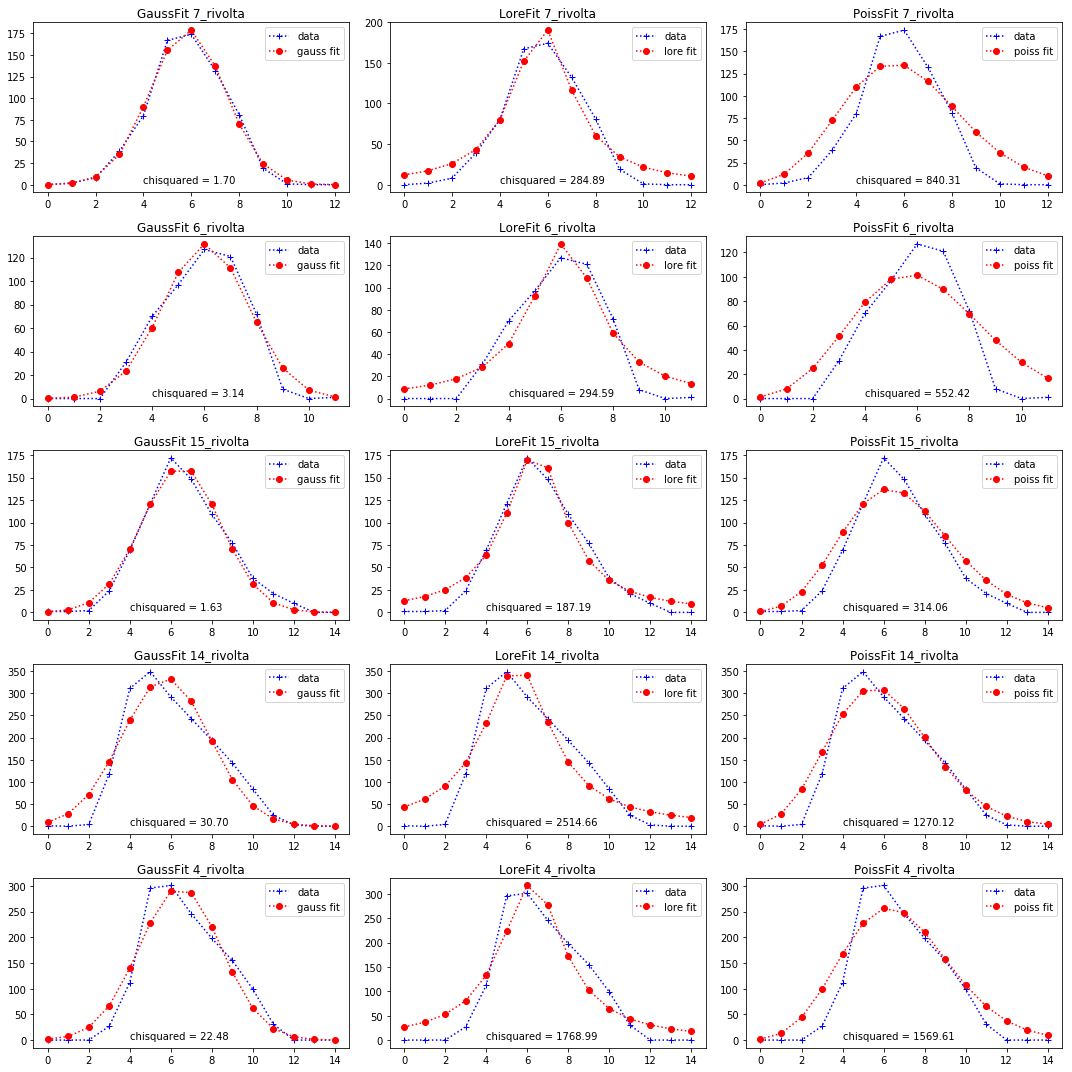

In [9]:
fig, ax = plt.subplots(nrows=len(choosen_list), ncols=3, figsize=(15,15))


for i, rivolta in enumerate(choosen_list):
    
    y = rivolte_dict[rivolta]
    x = range(len(y))
    
    gauss_params,gauss_cov = curve_fit(gauss,x,y)
    ##computo errore come larghezza a metà altezza
    sigma_gauss = 2*sqrt(np.abs(gauss_params[2]*gauss_params[2]*2*log(2)))
    gauss_red_chisq = chiquadronorm(y, gauss(x,*gauss_params), sigma_gauss, len(y)-3, norm=True)
    print('sigma:', gauss_params[2])
    print('errore: ', sigma_gauss)
    lore_params,lore_cov = curve_fit(lore,x,y)
    sigma_lore = 1 
    lore_red_chisq = chiquadronorm(y, lore(x,*lore_params), sigma_lore, len(y)-3, norm=True)
    
    poiss_params,poiss_cov = curve_fit(poisson,x,y)
    sigma_poiss = 1 
    poiss_red_chisq = chiquadronorm(y, poisson(x, *poiss_params), sigma_poiss, len(y)-2, norm=True)
    
    ax[i][0].plot(x,y,'b+:',label='data')
    ax[i][0].plot(x,gauss(x,*gauss_params),'ro:',label='gauss fit')
    ax[i][0].legend()
    ax[i][0].text(4,2,'chisquared = %.2f' % (gauss_red_chisq))
    ax[i][0].title.set_text('GaussFit ' + rivolta)
    
    ax[i][1].plot(x,y,'b+:',label='data')
    ax[i][1].plot(x,lore(x,*lore_params),'ro:',label='lore fit')
    ax[i][1].legend()
    ax[i][1].text(4,2,'chisquared = %.2f' % (lore_red_chisq))
    ax[i][1].title.set_text('LoreFit ' + rivolta)
    
    ax[i][2].plot(x,y,'b+:',label='data')
    ax[i][2].plot(x,poisson(x,*poiss_params),'ro:',label='poiss fit')
    ax[i][2].legend()
    ax[i][2].text(4,2,'chisquared = %.2f' % (poiss_red_chisq))
    ax[i][2].title.set_text('PoissFit ' + rivolta)

fig.tight_layout()
fig.show()